<a href="https://colab.research.google.com/github/rcpaffenroth/dac_raghu/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load data

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

import json

In [2]:
name = 'circle'
# Read the json info file
with open(f'../data/processed/info.json') as f:
    info = json.load(f)
# Read the start data
x_start = pd.read_parquet(f'../data/processed/{name}_start.parquet')
# Read the target data
x_target = pd.read_parquet(f'../data/processed/{name}_target.parquet')


# Dynamical system

In [3]:
x_size = x_start.shape[1]

# # A pytorch module that multiplies the output of two other modules, where the two modules are given as arguments to the constructor, and the fo
# # The forward method takes a single argument and returns a single tensor.
# class Multiply(nn.Module):
#     def __init__(self, module1, module2):
#         super().__init__()
#         self.module1 = module1
#         self.module2 = module2
#     def forward(self, x):
#         return self.module1(x) * self.module2(x)

# map = Multiply(nn.Linear(x_size, x_size), nn.Linear(x_size, x_size)) 

map = nn.Sequential(nn.Linear(x_size, 100), nn.ReLU(), nn.Linear(100, x_size))

In [4]:
# Turn a pandas dataframe into a pytorch tensor
def df_to_tensor(df):
    return torch.tensor(df.values, dtype=torch.float32)

# Make two pytorch tensor datasets from the start and target data
x_start_tensor = df_to_tensor(x_start)
x_target_tensor = df_to_tensor(x_target)

# a dataloader which returns a batch of start and target data
class Data(torch.utils.data.Dataset):
    def __init__(self, x_start, x_target):
        self.x_start = x_start
        self.x_target = x_target
    def __len__(self):
        return len(self.x_start)
    def __getitem__(self, idx):
        return self.x_start[idx], self.x_target[idx]
    
train_data = Data(x_start_tensor, x_target_tensor)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)

In [5]:
# Define the loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(map.parameters(), lr=0.001)

In [6]:
max_epochs = 200
# Train the model
for epoch in range(max_epochs):
    for batch_idx, (start, target) in enumerate(train_loader):
        optimizer.zero_grad()
        mapped = map(start)
        loss = criterion(mapped, target)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Batch {batch_idx}, Loss {loss.item()}')

Epoch 0, Batch 9, Loss 0.3646121919155121
Epoch 10, Batch 9, Loss 0.006788588594645262
Epoch 20, Batch 9, Loss 0.004737956449389458
Epoch 30, Batch 9, Loss 0.004308605566620827
Epoch 40, Batch 9, Loss 0.0036216964945197105
Epoch 50, Batch 9, Loss 0.002807686571031809
Epoch 60, Batch 9, Loss 0.002286303788423538
Epoch 70, Batch 9, Loss 0.001589186955243349
Epoch 80, Batch 9, Loss 0.0014834973262622952
Epoch 90, Batch 9, Loss 0.0006970560643821955
Epoch 100, Batch 9, Loss 0.0005689128302037716
Epoch 110, Batch 9, Loss 0.0004930554423481226
Epoch 120, Batch 9, Loss 0.0002592692035250366
Epoch 130, Batch 9, Loss 0.00017066439613699913
Epoch 140, Batch 9, Loss 0.00014427387213800102
Epoch 150, Batch 9, Loss 9.787675662664697e-05
Epoch 160, Batch 9, Loss 7.168786396505311e-05
Epoch 170, Batch 9, Loss 5.9575875638984144e-05
Epoch 180, Batch 9, Loss 6.555367144756019e-05
Epoch 190, Batch 9, Loss 5.607055572909303e-05


# Training data

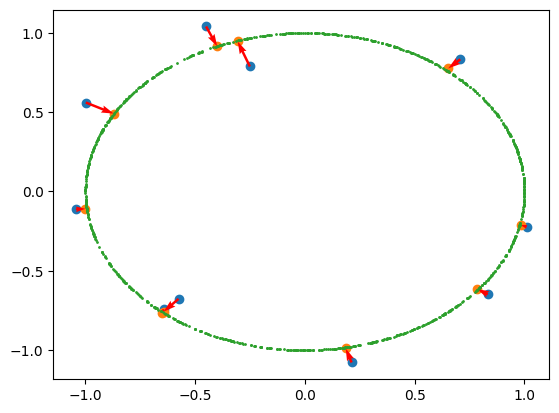

In [7]:
mapped_tensor = map(x_start_tensor).detach()
plot_points = 10

plt.figure()

plt.scatter(x_start_tensor[:plot_points,0], x_start_tensor[:plot_points,1])
plt.scatter(mapped_tensor[:plot_points,0], mapped_tensor[:plot_points,1])
dx = mapped_tensor[:plot_points,0]-x_start_tensor[:plot_points,0]
dy = mapped_tensor[:plot_points,1]-x_start_tensor[:plot_points,1]
plt.quiver(x_start_tensor[:plot_points,0], x_start_tensor[:plot_points,1], dx, dy, scale=1, scale_units='xy', angles='xy', color='r', width=0.005)

plt.scatter(x_target_tensor[:,0], x_target_tensor[:,1], s=1)
plt.show()

# Testing data

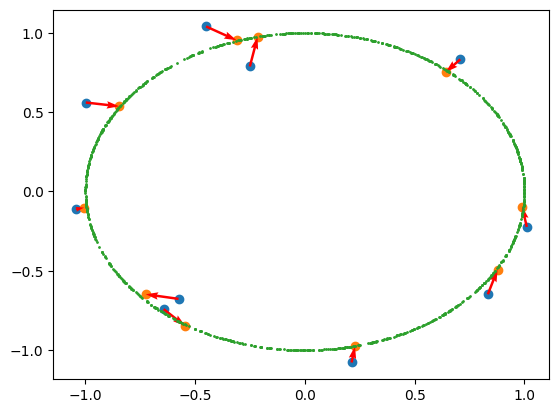

In [8]:
mapped_tensor = map(x_start_tensor+torch.rand_like(x_start_tensor)*0.2).detach()
plot_points = 10

plt.figure()

plt.scatter(x_start_tensor[:plot_points,0], x_start_tensor[:plot_points,1])
plt.scatter(mapped_tensor[:plot_points,0], mapped_tensor[:plot_points,1])
dx = mapped_tensor[:plot_points,0]-x_start_tensor[:plot_points,0]
dy = mapped_tensor[:plot_points,1]-x_start_tensor[:plot_points,1]
plt.quiver(x_start_tensor[:plot_points,0], x_start_tensor[:plot_points,1], dx, dy, scale=1, scale_units='xy', angles='xy', color='r', width=0.005)

plt.scatter(x_target_tensor[:,0], x_target_tensor[:,1], s=1)
plt.show()

# Iterated model

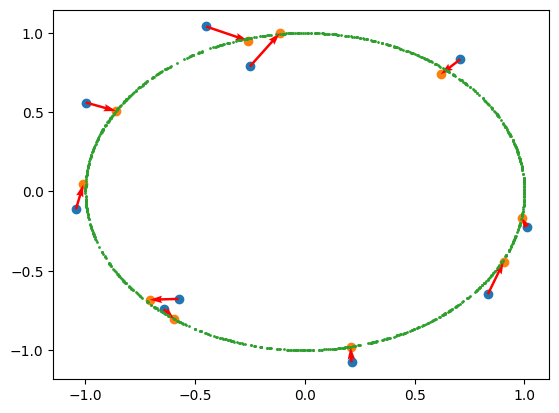

In [9]:
mapped_tensor = map(x_start_tensor+torch.rand_like(x_start_tensor)*0.2).detach()
plot_points = 10

plt.figure()

plt.scatter(x_start_tensor[:plot_points,0], x_start_tensor[:plot_points,1])
plt.scatter(mapped_tensor[:plot_points,0], mapped_tensor[:plot_points,1])
dx = mapped_tensor[:plot_points,0]-x_start_tensor[:plot_points,0]
dy = mapped_tensor[:plot_points,1]-x_start_tensor[:plot_points,1]
plt.quiver(x_start_tensor[:plot_points,0], x_start_tensor[:plot_points,1], dx, dy, scale=1, scale_units='xy', angles='xy', color='r', width=0.005)

plt.scatter(x_target_tensor[:,0], x_target_tensor[:,1], s=1)
plt.show()

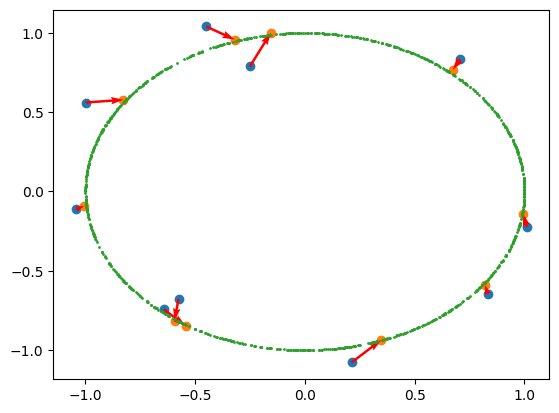

In [10]:
mapped_tensor = map(map(map(map(map(x_start_tensor+torch.rand_like(x_start_tensor)*0.2))))).detach()
plot_points = 10

plt.figure()

plt.scatter(x_start_tensor[:plot_points,0], x_start_tensor[:plot_points,1])
plt.scatter(mapped_tensor[:plot_points,0], mapped_tensor[:plot_points,1])
dx = mapped_tensor[:plot_points,0]-x_start_tensor[:plot_points,0]
dy = mapped_tensor[:plot_points,1]-x_start_tensor[:plot_points,1]
plt.quiver(x_start_tensor[:plot_points,0], x_start_tensor[:plot_points,1], dx, dy, scale=1, scale_units='xy', angles='xy', color='r', width=0.005)

plt.scatter(x_target_tensor[:,0], x_target_tensor[:,1], s=1)
plt.show()

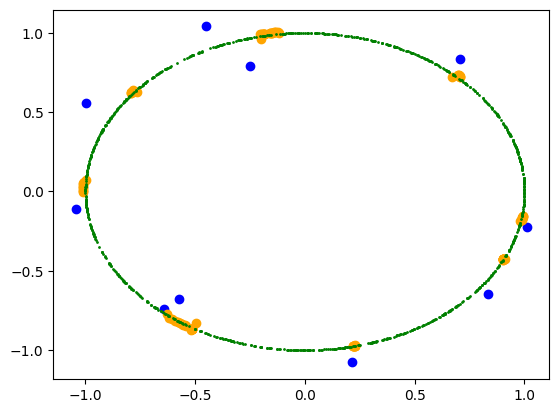

In [11]:
plot_points = 10

plt.figure()

plt.scatter(x_start_tensor[:plot_points,0], x_start_tensor[:plot_points,1], c='blue')

mapped_tensor = map(x_start_tensor+torch.rand_like(x_start_tensor)*0.2)

for i in range(10):
    plt.scatter(mapped_tensor[:plot_points,0].detach(), mapped_tensor[:plot_points,1].detach(), c='orange')
    mapped_tensor = map(mapped_tensor)

plt.scatter(x_target_tensor[:,0], x_target_tensor[:,1], s=1, c='green')
plt.show()